
# Library



In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
import matplotlib.dates as mdates
import sklearn.metrics as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from scipy import stats

In [77]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/
df= pd.read_csv('google-stock-dataset-Daily.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


#data

In [78]:
df= df.drop(['Unnamed: 0'], axis=1)
df= df.drop(['Volume'], axis=1)
df= df.drop(['Adj Close'], axis=1)
df.set_index("Date", inplace=True)


In [79]:
# Test for stationary using ADF (Augmented Dicket-Fuller Test)
def is_stationary(df):
    result = adfuller(df)
    test_statistic = result[0]
    p_value = result[1]
    ciritcal_values = result[4]

    for key, value in result[4].items():
        if test_statistic > value:
            return False
    return True

# Converting non-stationary to stationary
def convert_to_stationary(df):
    df_log = np.sqrt(df)
    df_diff = df_log.diff().dropna()
    return df_diff

# Revert back to non stationary data
def revert_to_non_stationary(init, stat_df):
    df_rev_diff = np.r_[init, stat_df].cumsum()

    #df_square = np.square(df_rev_diff)
    return df_rev_diff

In [92]:
data = pd.DataFrame()
for col in list(df):
    if not is_stationary(df[col]):
        data[col] = convert_to_stationary(df[col])
        continue
    data[col] = df[col]

In [98]:
#### PREPROCESSING ####
data = data.dropna() # Drop missing data

# x_data = raw_df.iloc[:, raw_df.columns != 'Volume'].values # x_data.shape = (2510, 6)
x_data = data.drop(['Close'], axis=1)
y_data= data['Close']

# Divide into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=False)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Train the KNN regressor
# Replace with your desired value of k
knn = KNeighborsRegressor(n_neighbors = 5)
knn.fit(x_train_scaled, y_train)

# Make predictions on the test set
x_pred = knn.predict(x_train_scaled)
y_pred = knn.predict(x_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_train, x_pred)
mse1 = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train, x_pred)
mae1 = mean_absolute_error(y_test, y_pred)

# Print the results
print('Mean Square Error: {}'.format(mse))
print('Mean sbsolute Error: {}'.format(mse1))
print('Mean Aquare Error: {}'.format(mae))
print('Mean Absolute Error: {}'.format(mae1))
r2 = r2_score(y_test, y_pred)
r21 = r2_score(y_train, x_pred)
print("R-squared score:", round(r2*100,2) ,"%")
print("R-squared score:", round(r21*100,2) ,"%")

Mean Square Error: 0.0007079760616654337
Mean sbsolute Error: 0.0033661949875046777
Mean Aquare Error: 0.017386832871745028
Mean Absolute Error: 0.042740865363747806
R-squared score: 72.7 %
R-squared score: 79.24 %


In [82]:

data = df

 # Split the data into features and target variable
X = data
y = data['Close']
from sklearn.model_selection import TimeSeriesSplit

train_index=[]
test_index=[]
tscv = TimeSeriesSplit(n_splits=5)
for train, test in tscv.split(data):
  train_index.append(train.tolist())
  test_index.append(test.tolist())

# Split the data into features (X) and target variable (y)
X_train, X_test = X.iloc[train_index[4]], X.iloc[test_index[4]]
Y_train, Y_test = y.iloc[train_index[4]], y.iloc[test_index[4]]
restore_point=135.13


In [100]:
comparison_table = pd.DataFrame({'Date':y_test.index,'Actual_Value': revert_to_non_stationary(restore_point, y_test)[1:], 'Predicted_Value': revert_to_non_stationary(restore_point,y_pred)[1:]})

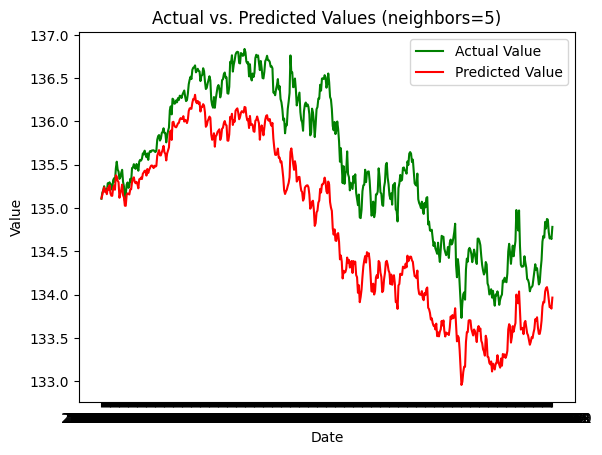

In [89]:
fig, ax = plt.subplots()

# Plot Actual Value in green
ax.plot(comparison_table['Date'], comparison_table['Actual_Value'], color='green', label='Actual Value')

# Plot Predicted Value in red
ax.plot(comparison_table['Date'], comparison_table['Predicted_Value'], color='red', label='Predicted Value')

# Add a legend
ax.legend()

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Actual vs. Predicted Values (neighbors=5)')

plt.show()

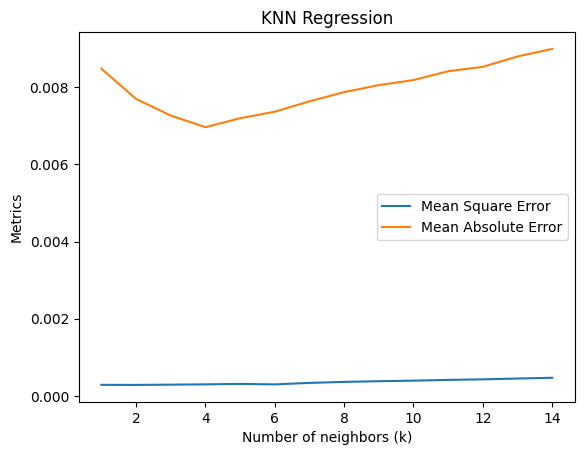

In [93]:
# Define a list of k values to evaluate
k_values = []
for k in range (1,15,1):
  k_values.append(k)

mse1 = []
mae1 = []
r2=[]

# Iterate over different values of k
for k in k_values:
    data = data.dropna() # Drop missing data

    # Split the data into features (X) and target variable (y)
    X = data[['Price', 'High', 'Low','Close']]  # Replace with your own feature columns
    y = data['Close']  # Replace with your own target variable column

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mse1.append(mse)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    mae1.append(mae)

    r2_c = r2_score(y_test, y_pred)
    r2.append(r2_c)

# Plot the loss curves
plt.plot(k_values, mse1, label='Mean Square Error')
plt.plot(k_values, mae1, label='Mean Absolute Error')
# plt.plot(k_values, r2, label='r2 score')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Metrics')
plt.title('KNN Regression')
plt.legend()
plt.show()

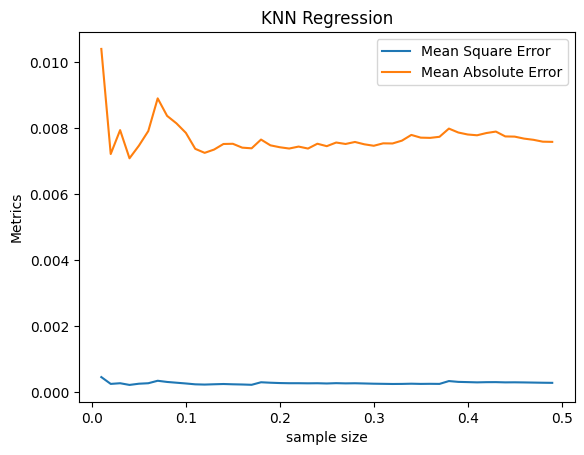

In [20]:
# Define a list of sample sizes to evaluate
sample_sizes =[]
for k in range (1,50,1):
  sample_sizes.append(k/100)

# Initialize lists to store
mse2 = []
mae2 = []

# Iterate over different sample sizes
for k in sample_sizes:
    data = data.dropna() # Drop missing data

    # Split the data into features (X) and target variable (y)
    X = data[['Price', 'High', 'Low','Close']]  # Replace with your own feature columns
    y = data['Close']  # Replace with your own target variable column

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k, random_state=0)

    # Scale the features using standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    knn = KNeighborsRegressor(n_neighbors = 5)
    knn.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mse2.append(mse)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    mae2.append(mae)

# Plot the loss curves
plt.plot(sample_sizes, mse2, label='Mean Square Error')
plt.plot(sample_sizes, mae2, label='Mean Absolute Error')
plt.xlabel('sample size')
plt.ylabel('Metrics')
plt.title('KNN Regression')
plt.legend()
plt.show()

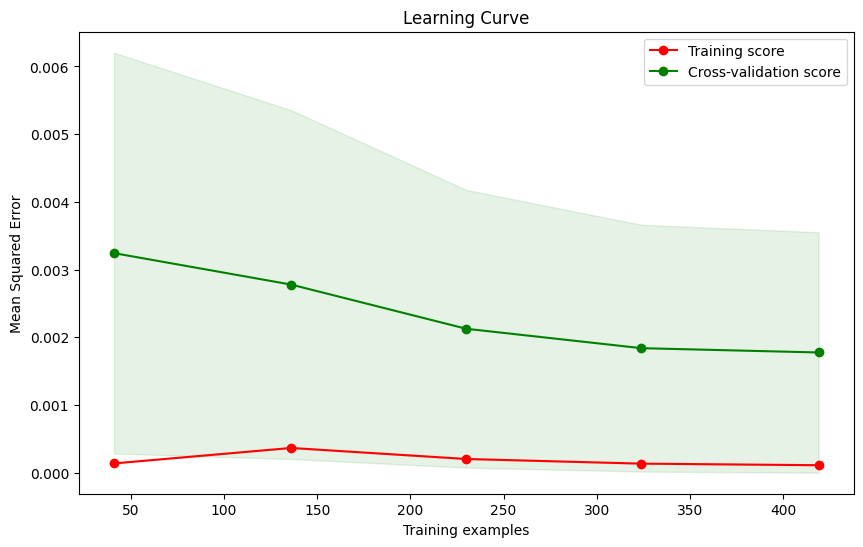

In [99]:
train_sizes = np.linspace(0.1, 1.0, 5)
scoring = 'neg_mean_squared_error'  # Choose an appropriate scoring metric
from sklearn.model_selection import learning_curve
nonsta_reg = KNeighborsRegressor()
# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=nonsta_reg,
    X=X,
    y=y,
    train_sizes=train_sizes,
    cv=tscv,
    scoring=scoring,
    n_jobs=1  # Set the number of jobs to run in parallel, adjust as needed
)
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)
plt.plot(
    train_sizes,
    train_scores_mean,
    'o-', color="r",
    label="Training score"
)
plt.plot(
    train_sizes,
    test_scores_mean,
    'o-', color="g",
    label="Cross-validation score"
)
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()